# Setup the environment

Importing the required libraries 

In [2]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('finalProject')

sc

<SparkContext master=local[*] appName=PySparkShell>

In [1]:
#from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions
from pyspark.mllib.stat import Statistics
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel, SVMModel, SVMWithSGD
from pyspark.mllib.evaluation import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import pandas as pd
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature

In [2]:
#For the random forest model
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, VectorIndexer, StringIndexer, SQLTransformer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve, auc
from pyspark.ml.classification import RandomForestClassifier
import pandas as pd
import numpy as np

In [3]:
# For the Kmeans model
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from __future__ import division
get_ipython().magic(u'matplotlib inline')
import pandas as pd
import numpy as np

# Visualize the data

### Individual feature visualizations

_3
            255
female    10148
male      12784
Name: _3, dtype: int64


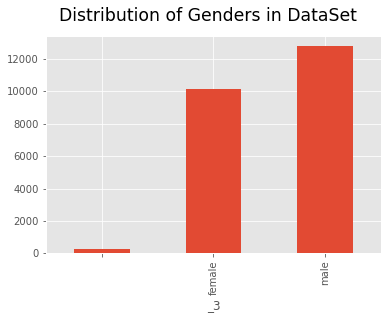

In [309]:
import pandas as pd
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

dataFile = sc.textFile("file:///home/cloudera/Downloads/data.csv")
def parseLine2(line):
    fields = line.split(',')
    city = int(fields[1])
    age = int(fields[2])
    gender = str(fields[3])
    registered_via = int(fields[4])
    registered_date = str(fields[5])
    is_churn = int(fields[7])
    payment_method = int(fields[8])
    payment_plan_days = int(fields[9])
    plan_list_price = int(fields[10])
    actual_amount_paid = int(fields[11])
    is_auto_renew = int(fields[12])
    transaction_date = str(fields[13])
    membership_expire_date = str(fields[15])
    time_on_board = int(fields[17])
    is_cancel =  int(fields[18])
    num_25 = str(fields[19])
    num_50 = str(fields[20])
    num_75 = str(fields[21])
    num_985 = str(fields[22])
    num_100 = str(fields[23])
    num_unq = str(fields[24])
    total_secs = str(fields[25])
    return (city, 
            age, 
            gender, 
            registered_via, 
            registered_date, 
            is_churn,
            payment_method,
            payment_plan_days,
            plan_list_price,
           actual_amount_paid,
           is_auto_renew,
           transaction_date,
           membership_expire_date,
           time_on_board,
           is_cancel,
           num_25,
           num_50,
           num_75,
           num_985,
           num_100,
           num_unq,
           total_secs
           )

parsedData1 =dataFile.map(parseLine2)
parsedData1 = parsedData1.toDF()
parsedData1 = parsedData1.toPandas()


params = {'figure.titlesize':'xx-large'}
pylab.rcParams.update(params)


matplotlib.style.use('ggplot')
%matplotlib inline

print(parsedData1.groupby('_3')._3.count())

plt.figure().suptitle('Distribution of Genders in DataSet')
parsedData1.groupby('_3')._3.count().plot.bar()
    



_6
0    20447
1     2740
Name: _6, dtype: int64


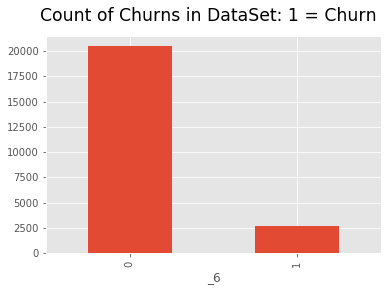

In [310]:
plt.figure().suptitle('Count of Churns in DataSet: 1 = Churn')
print(parsedData1.groupby('_6')._6.count())
parsedData1.groupby('_6')._6.count().plot.bar()

_3
            37
female    1161
male      1542
Name: _6, dtype: int64


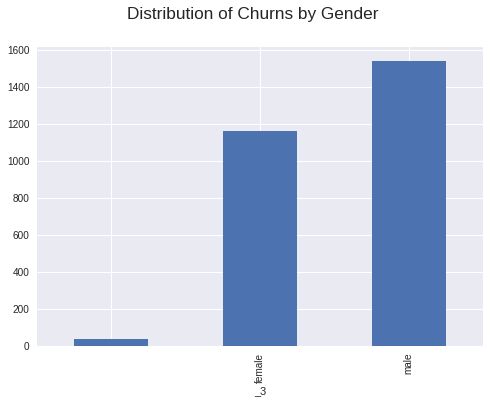

In [311]:
churned = parsedData1[parsedData1._6 == 1]
print(churned.groupby('_3')._6.count())
matplotlib.style.use('seaborn')
plt.figure().suptitle('Distribution of Churns by Gender')
churned.groupby('_3')._6.count().plot.bar()

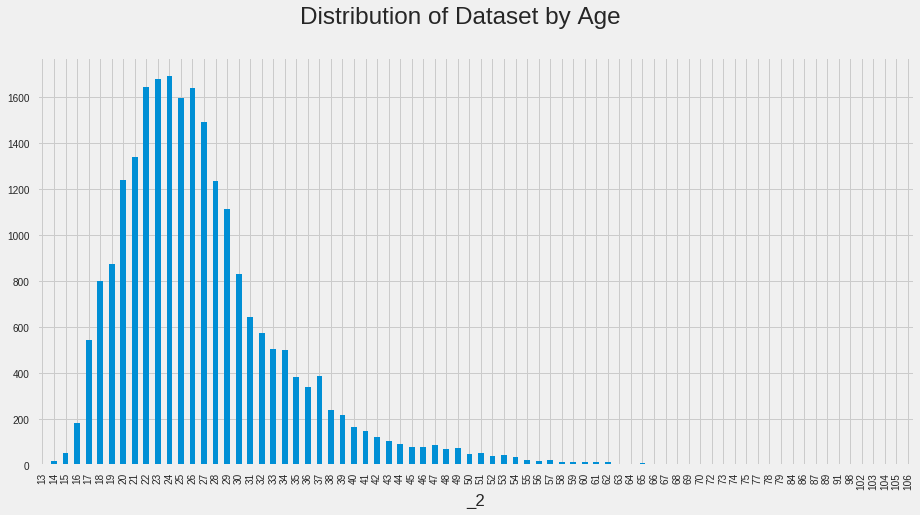

In [312]:
matplotlib.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']= [14,7]
#print(parsedData1.groupby('_2')._2.count())
plt.figure().suptitle('Distribution of Dataset by Age')
parsedData1.groupby('_2')._2.count().plot.bar()
plt.rcParams['figure.figsize']= [5,4]

# Build the Support Vector Machine model


Below reads in a copy of the original dataset conraining only the numeric values and runs a correlation matrix in preperation of support vector machine model building.


In [313]:
def parsePoint(line):
    values = [float(x) for x in line.split(',')]
    return (values[0:])

data = sc.textFile("file:///home/cloudera/Downloads/NumData1.csv")
parsedData = data.map(parsePoint)

print(Statistics.corr(parsedData, method="pearson"))


[[ 1.         -0.01554822 -0.06133734 -0.23735009  0.50152512  0.46450568
   0.45602716 -0.2921989   0.0047002   0.27554777]
 [-0.01554822  1.         -0.00460573  0.03765283 -0.02122925 -0.02336196
  -0.02398442  0.04448044  0.04754263 -0.01119986]
 [-0.06133734 -0.00460573  1.          0.08780204 -0.03980385 -0.03184646
  -0.0311362   0.26667379  0.07681534  0.01178509]
 [-0.23735009  0.03765283  0.08780204  1.         -0.30661551 -0.24793639
  -0.24046956  0.21348827  0.06113444  0.00612286]
 [ 0.50152512 -0.02122925 -0.03980385 -0.30661551  1.          0.95842553
   0.9565366  -0.30966061  0.0940819  -0.03184937]
 [ 0.46450568 -0.02336196 -0.03184646 -0.24793639  0.95842553  1.
   0.99748467 -0.29459415  0.08364457 -0.02653817]
 [ 0.45602716 -0.02398442 -0.0311362  -0.24046956  0.9565366   0.99748467
   1.         -0.2973673   0.08606542 -0.02541142]
 [-0.2921989   0.04448044  0.26667379  0.21348827 -0.30966061 -0.29459415
  -0.2973673   1.          0.14022643  0.10285249]
 [ 0.004

In [ ]:
params = {'figure.titlesize':'xx-large'}
pylab.rcParams.update(params)


matplotlib.style.use('ggplot')
%matplotlib inline

print(parsedData1.groupby('_3')._3.count())

plt.figure().suptitle('Distribution of Genders in DataSet')
parsedData1.groupby('_3')._3.count().plot.bar()


With some correlated data. The support vector machine model is built below


In [299]:
# Load and parse the data for the regression analysis.
def parsePoint(line):
    values = [float(x) for x in line.split(',')]
    return LabeledPoint(values[0], values[1:])

data = sc.textFile("file:///home/cloudera/Downloads/NumData2.csv")
parsedData = data.map(parsePoint)

# Splits the data into a 60% training 40% testing set with a set seed for repeatability.
train, test = parsedData.randomSplit([0.6, 0.4], seed = 2018)



In [300]:
# Build the model as from Spark 1.6 API documentation. 200 Interations was found to provide good results
SVMmodel = SVMWithSGD.train(train, iterations=200)

# our true data and predications
SVMlabelsAndPreds= train.map(lambda p: (float(SVMmodel.predict(p.features)), p.label)).cache()

In [302]:
trainErr = SVMlabelsAndPreds.filter(lambda (v, p): v != p).count() / float(train.count())
metricsM = MulticlassMetrics(SVMlabelsAndPreds)
metricsBC = BinaryClassificationMetrics(SVMlabelsAndPreds)
print("Training Error = " + str(trainErr))
print("The area under ROC is " + '%.2f' % metricsBC.areaUnderROC + " -- A value of 1 is the best")
print("The area under the PR is " + '%.2f' % metricsBC.areaUnderPR + " -- A value of 1 is the best")
print("Confusion Matrix Below: it has a 8% False Negative Rate and a 62% False Positive Rate ")
print(metricsM.confusionMatrix().toArray())

Training Error = 0.104061644822
The area under ROC is 0.64 -- A value of 1 is the best
The area under the PR is 0.50 -- A value of 1 is the best
Confusion Matrix Below: it has a 8% False Negative Rate and a 62% False Positive Rate 
[[ 11952.    301.]
 [  1144.    489.]]


## Visualise the classifier results

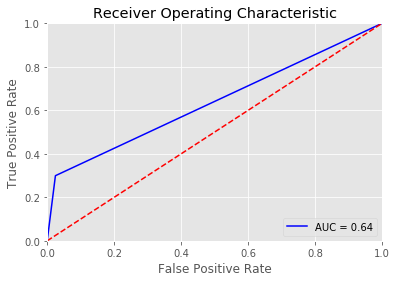

In [291]:
#calculate the fpr and tpr for all thresholds of the classification
#adapted from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

#convereted to dataframes to use plotting/graphing libraries
SVMlabelsAndPreds2 = SVMlabelsAndPreds.toDF()
SVMlabelsAndPreds2 = SVMlabelsAndPreds2.toPandas()

SVMprobs = SVMlabelsAndPreds2['_2']
SVMpreds = SVMlabelsAndPreds2['_1']
fpr, tpr, threshold = metrics.roc_curve(SVMprobs, SVMpreds)
roc_auc = metrics.auc(fpr, tpr)

#start building the graph
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

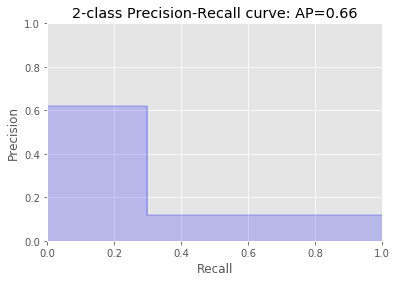

In [292]:
# code adapted from scikit-learn.org

precision, recall, _ = precision_recall_curve(SVMprobs, SVMpreds)


step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [304]:
SvmTestlabelsAndPreds = test.map(lambda p: (float(model.predict(p.features)), p.label)).cache()
metricsM = MulticlassMetrics(SvmTestlabelsAndPreds)
metricsBC = BinaryClassificationMetrics(SvmTestlabelsAndPreds)
print("The area under ROC is " + '%.2f' % metricsBC.areaUnderROC + " -- A value of 1 is the best")
print("The area under the PR is " + '%.2f' % metricsBC.areaUnderPR + " -- A value of 1 is the best")
print("Confusion Matrix Below: it has a 8% False Negative Rate and 32% False Positive Rate ")
print(metricsM.confusionMatrix().toArray())

The area under ROC is 0.66 -- A value of 1 is the best
The area under the PR is 0.42 -- A value of 1 is the best
Confusion Matrix Below: it has a 8% False Negative Rate and 32% False Positive Rate 
[[ 7086.  1108.]
 [  600.   507.]]


# Logisitic Regression Model

We remove the correlated attributes as logisitic regression can be more sensitive to them

In [ ]:
def parsePoint(line):
    values = [float(x) for x in line.split(',')]
    return (values[0:])

data = sc.textFile("file:///home/cloudera/Downloads/NumData2.csv")
parsedData = data.map(parsePoint)

print(Statistics.corr(parsedData, method="pearson"))

In [ ]:
# Build the model as from Spark 1.6 API documentation
lrModel =  LogisticRegressionWithLBFGS.train(train, iterations=100)

# our true data and predications
lrLabelsAndPreds= train.map(lambda p: (float(model.predict(p.features)), p.label)).cache()

Below starts the metrics for the training data set.

In [243]:
trainErr = lrLabelsAndPreds.filter(lambda (v, p): v != p).count() / float(train.count())
metricsM = MulticlassMetrics(lrLabelsAndPreds)
metricsBC = BinaryClassificationMetrics(lrLabelsAndPreds)
print("Training Error = " + str(trainErr))
print("The area under ROC is " + '%.2f' % metricsBC.areaUnderROC + " -- A value of 1 is the best")
print("The area under the PR is " + '%.2f' % metricsBC.areaUnderPR + " -- A value of 1 is the best")
print("Confusion Matrix Below: it has a 7% False Negative Rate and 18.5% False Positive Rate ")
print(metricsM.confusionMatrix().toArray())


Training Error = 0.0773440875702
The area under ROC is 0.71 -- A value of 1 is the best
The area under the PR is 0.66 -- A value of 1 is the best
Confusion Matrix Below: it has a 7% False Negative Rate and 18.5% False Positive Rate 
[[ 12089.    164.]
 [   910.    723.]]



Below is a graphical representation of the area under ROC and Precision Recall


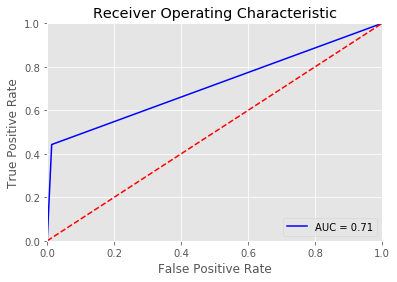

In [255]:
#calculate the fpr and tpr for all thresholds of the classification
#adapted from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

#convereted to dataframes to use plotting/graphing libraries
lrLabelsAndPreds2 = lrLabelsAndPreds.toDF()
lrLabelsAndPreds2 = lrLabelsAndPreds2.toPandas()

probs = lrLabelsAndPreds2['_2']
preds = lrLabelsAndPreds2['_1']
fpr, tpr, threshold = metrics.roc_curve(probs, preds)
roc_auc = metrics.auc(fpr, tpr)

#start building the graph
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

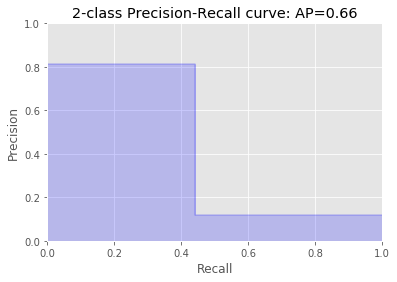

In [256]:
# code adapted from scikit-learn.org
precision, recall, _ = precision_recall_curve(probs, preds)


step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))


Below starts the the metrics for the test data set. It barely performs better than the training dataset


In [257]:
lrLabelsAndPreds = test.map(lambda p: (float(lrModel.predict(p.features)), p.label)).cache()
metricsM = MulticlassMetrics(lrLabelsAndPreds)
metricsBC = BinaryClassificationMetrics(lrLabelsAndPreds)
print("The area under ROC is " + '%.2f' % metricsBC.areaUnderROC + " -- A value of 1 is the best")
print("The area under the PR is " + '%.2f' % metricsBC.areaUnderPR + " -- A value of 1 is the best")
print("Confusion Matrix Below: it has a 7% False Negative Rate and 15% False Positive Rate ")
print(metricsM.confusionMatrix().toArray())

The area under ROC is 0.72 -- A value of 1 is the best
The area under the PR is 0.68 -- A value of 1 is the best
Confusion Matrix Below: it has a 7% False Negative Rate and 15% False Positive Rate 
[[ 8103.    91.]
 [  602.   505.]]


# Build the Random Forests Model

Loading the data from CSV file

In [6]:
churn_data = spark.read.csv('file:///home/cloudera/Downloads/data.csv', header=True, inferSchema=True)
churn_data.printSchema()

root
 |-- msno: string (nullable = true)
 |-- city: integer (nullable = true)
 |-- bd: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- registered_via: integer (nullable = true)
 |-- registration_init_time: integer (nullable = true)
 |-- Column1: string (nullable = true)
 |-- Is_Churn: integer (nullable = true)
 |-- payment_method_id: integer (nullable = true)
 |-- payment_plan_days: integer (nullable = true)
 |-- plan_list_price: integer (nullable = true)
 |-- actual_amount_paid: integer (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- transaction_date: integer (nullable = true)
 |-- Column2: string (nullable = true)
 |-- membership_expire_date: integer (nullable = true)
 |-- Column3: string (nullable = true)
 |-- Time on board: integer (nullable = true)
 |-- is_cancel: integer (nullable = true)
 |-- num_25: string (nullable = true)
 |-- num_50: string (nullable = true)
 |-- num_75: string (nullable = true)
 |-- num_985: string (nullable = true)

Verifying if the data is loaded properly

In [7]:
churn_data.limit(5).toPandas()

,msno,city,bd,gender,registered_via,registration_init_time,Column1,Is_Churn,payment_method_id,payment_plan_days,...,Time on board,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,Loyalty
0,Uf4DL7z+DPK8Pnb82pao8tC2PfSTuwIvlVDDqUru8SA=,5,32,female,3,20141221,12/21/2014,1,38,90,...,920,0,8,4,1,4,36,36,10430.627,0
1,7KuGYecfAiQCvs2ktZg4aaFvcudRNevM2LqsHGVashU=,5,32,female,3,20131207,12/7/2013,0,40,30,...,1226,0,7,1,0,1,21,29,5619.767,5
2,CqnzYX4UnocVkbygvMXzr6mdRamPSphCOfx/xl7ucPo=,5,32,female,3,20130428,4/28/2013,0,36,30,...,1416,1,6,1,0,0,182,36,39684.049,5
3,qqM5POOe8//uuBUoANMczJibwta0YnUhvtPDVGTwjng=,5,32,female,3,20150920,9/20/2015,0,36,30,...,579,0,2,1,2,1,22,26,6026.237,4
4,EpbEiNi939eNb5EK6p8bE7c3heLnAHGK/qT9kgvxE+0=,5,32,female,3,20121016,10/16/2012,0,33,30,...,1632,0,#N/A,#N/A,#N/A,#N/A,#N/A,#N/A,#N/A,5


In [8]:
pd.DataFrame(churn_data.take(5), columns=churn_data.columns).transpose()

,0,1,2,3,4
msno,Uf4DL7z+DPK8Pnb82pao8tC2PfSTuwIvlVDDqUru8SA=,7KuGYecfAiQCvs2ktZg4aaFvcudRNevM2LqsHGVashU=,CqnzYX4UnocVkbygvMXzr6mdRamPSphCOfx/xl7ucPo=,qqM5POOe8//uuBUoANMczJibwta0YnUhvtPDVGTwjng=,EpbEiNi939eNb5EK6p8bE7c3heLnAHGK/qT9kgvxE+0=
city,5,5,5,5,5
bd,32,32,32,32,32
gender,female,female,female,female,female
registered_via,3,3,3,3,3
registration_init_time,20141221,20131207,20130428,20150920,20121016
Column1,12/21/2014,12/7/2013,4/28/2013,9/20/2015,10/16/2012
Is_Churn,1,0,0,0,0
payment_method_id,38,40,36,36,33
payment_plan_days,90,30,30,30,30


Displaying summary statistics for numeric variables including count, mean, stddev, min, and max.

In [9]:
numeric_data = [t[0] for t in churn_data.dtypes if t[1] == 'int']
churn_data.select(numeric_data).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
city,23187,5.675335317203605,2.057295458181949,3,11
bd,23187,26.921507741406824,7.619133868160284,13,106
registered_via,23187,3.0,0.0,3,3
registration_init_time,23187,2.0137633484581877E7,13417.056102839004,20111209,20170324
Is_Churn,23187,0.11816966403588218,0.3228158745633186,0,1
payment_method_id,23187,36.53465303834045,4.193000344427315,6,40
payment_plan_days,23187,39.357312287057404,49.97522057752058,1,450
plan_list_price,23187,191.44650019407428,202.3471265674394,0,1788
actual_amount_paid,23187,190.20222538491396,202.99028785611426,0,1788


Changing the blank values with NA( for city, registered_via and gender)

In [10]:
churn_data = churn_data.fillna({'gender': 'NA', 'city': 'NA', 'registered_via': 'NA'}) # fill in 'N/A' entries for certain cols

Removing the date columns from the dataframe as random forests only works with continuous variables. Printing the schema in a tree format.

In [11]:
churn_data = churn_data.select('city','bd', 'payment_method_id', 'payment_plan_days', 'registered_via', 'plan_list_price','actual_amount_paid', 'Time on board',
                              'gender', 'Is_Churn', 'is_auto_renew', 'is_cancel')
cols = churn_data.columns
churn_data.printSchema()

root
 |-- city: integer (nullable = true)
 |-- bd: integer (nullable = true)
 |-- payment_method_id: integer (nullable = true)
 |-- payment_plan_days: integer (nullable = true)
 |-- registered_via: integer (nullable = true)
 |-- plan_list_price: integer (nullable = true)
 |-- actual_amount_paid: integer (nullable = true)
 |-- Time on board: integer (nullable = true)
 |-- gender: string (nullable = false)
 |-- Is_Churn: integer (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- is_cancel: integer (nullable = true)



Convert categorical variables into column with indices.

In [12]:
# Indexing categorical column 'gender' using StringIndexer
genderIndexer = StringIndexer(inputCol = 'gender', outputCol = 'genderCat').fit(churn_data)

genderIndexer.transform(churn_data).select("gender", "genderCat").show()

churn_data = genderIndexer.transform(churn_data)

churn_data.printSchema()

+------+---------+
|gender|genderCat|
+------+---------+
|female|      1.0|
|female|      1.0|
|female|      1.0|
|female|      1.0|
|female|      1.0|
|female|      1.0|
|female|      1.0|
|female|      1.0|
|female|      1.0|
|female|      1.0|
|female|      1.0|
|female|      1.0|
|female|      1.0|
|female|      1.0|
|female|      1.0|
|female|      1.0|
|female|      1.0|
|female|      1.0|
|female|      1.0|
|female|      1.0|
+------+---------+
only showing top 20 rows

root
 |-- city: integer (nullable = true)
 |-- bd: integer (nullable = true)
 |-- payment_method_id: integer (nullable = true)
 |-- payment_plan_days: integer (nullable = true)
 |-- registered_via: integer (nullable = true)
 |-- plan_list_price: integer (nullable = true)
 |-- actual_amount_paid: integer (nullable = true)
 |-- Time on board: integer (nullable = true)
 |-- gender: string (nullable = false)
 |-- Is_Churn: integer (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- is_cancel: integer

Now we need to select input variables as features and target variable as label to apply predictive models on it.

In [13]:
tmp=[]
churn_data = churn_data.drop('gender')
Cols_now = churn_data.columns
Cols_now.remove('Is_Churn')
vectorAssembler = VectorAssembler(inputCols=Cols_now, outputCol='features')
labelIndexer = StringIndexer(inputCol='Is_Churn', outputCol='label') #Encoding the label to a column of label indices. 
tmp+=[vectorAssembler, labelIndexer]
pipeline = Pipeline(stages=tmp)

In [14]:
df= pipeline.fit(churn_data).transform(churn_data)
df.cache()

DataFrame[city: int, bd: int, payment_method_id: int, payment_plan_days: int, registered_via: int, plan_list_price: int, actual_amount_paid: int, Time on board: int, Is_Churn: int, is_auto_renew: int, is_cancel: int, genderCat: double, features: vector, label: double]

Splitting the data into training and test sets into a 70/30 ratio

In [16]:
train, test = df.randomSplit([0.7, 0.3], seed = 0) # set seed to ensure same split for every model

Printing the count of examples in train and test sets

In [17]:
print ("We have %d training examples and %d test examples." % (train.count(), test.count()))

We have 16293 training examples and 6894 test examples.


In [18]:
train.printSchema()

root
 |-- city: integer (nullable = true)
 |-- bd: integer (nullable = true)
 |-- payment_method_id: integer (nullable = true)
 |-- payment_plan_days: integer (nullable = true)
 |-- registered_via: integer (nullable = true)
 |-- plan_list_price: integer (nullable = true)
 |-- actual_amount_paid: integer (nullable = true)
 |-- Time on board: integer (nullable = true)
 |-- Is_Churn: integer (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- is_cancel: integer (nullable = true)
 |-- genderCat: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



Specifying the options for the random forest model

In [20]:
rf = RandomForestClassifier(labelCol='label', featuresCol="features", numTrees=100)

Training the model on training set and predicting outcomes for test data

In [21]:
fit = rf.fit(train)
transformed = fit.transform(test)

Verifying the predictions

In [22]:
transformed.select("prediction", "Is_Churn", "Features", 'rawPrediction','probability').show(10)

+----------+--------+--------------------+--------------------+--------------------+
|prediction|Is_Churn|            Features|       rawPrediction|         probability|
+----------+--------+--------------------+--------------------+--------------------+
|       0.0|       0|[3.0,16.0,36.0,30...|[93.1555053696588...|[0.93155505369658...|
|       0.0|       0|[3.0,17.0,28.0,30...|[91.3608640164808...|[0.91360864016480...|
|       0.0|       0|[3.0,17.0,29.0,30...|[91.4291685478432...|[0.91429168547843...|
|       0.0|       0|[3.0,17.0,29.0,30...|[94.5076758916432...|[0.94507675891643...|
|       0.0|       0|[3.0,17.0,38.0,30...|[91.3827773389143...|[0.91382777338914...|
|       0.0|       0|[3.0,18.0,29.0,30...|[92.1520734127744...|[0.92152073412774...|
|       0.0|       0|[3.0,18.0,36.0,30...|[91.3331454438628...|[0.91333145443862...|
|       0.0|       0|[3.0,18.0,36.0,30...|[94.3999289859191...|[0.94399928985919...|
|       0.0|       0|[3.0,18.0,36.0,30...|[94.4634871762592...|[0

Evaluating Area Under Curve (AUC) for model on test data

In [23]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(transformed, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8543257712504092


Calculating test error

In [25]:
accuracy = evaluator.evaluate(transformed)
print("Test Error (@ 100 trees:) = %g" % (1.0 - accuracy))

Test Error (@ 100 trees:) = 0.145674


Area Under PR for test data.

In [26]:
metric2 = evaluator.evaluate(transformed,{evaluator.metricName: 'areaUnderPR'})
print("Area under Precision/Recall (PR) curve: %.f" % (metric2 * 100))

Area under Precision/Recall (PR) curve: 72


## Visualizing the classifier results

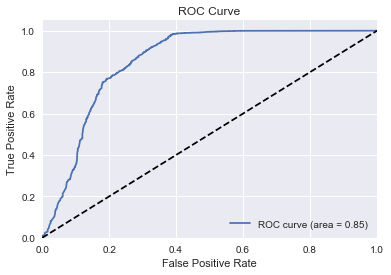

In [27]:
#Visualize the AUC score by drawing areaunderROC curve
# code adapted from 'https://weiminwang.blog/2016/06/09/pyspark-tutorial-building-a-random-forest-binary-classifier
#-on-unbalanced-dataset/' for plotting the AreaUnderROC curve
import matplotlib as mplt

fposrate = dict()
tposrate = dict()
roc_auc = dict()

trainSummary = transformed.select(['probability','label'])

## prepare score-label set
results_collect = trainSummary.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fposrate, tposrate, _ = roc_curve(y_test, y_score)
roc_auc = auc(fposrate, tposrate)
 
%matplotlib inline
mplt.pyplot.figure()
mplt.pyplot.plot(fposrate, tposrate, label='ROC curve (area = %0.2f)' % roc_auc)
mplt.pyplot.plot([0, 1], [0, 1], 'k--')
mplt.pyplot.xlim([0.0, 1.0])
mplt.pyplot.ylim([0.0, 1.05])
mplt.pyplot.xlabel('False Positive Rate')
mplt.pyplot.ylabel('True Positive Rate')
mplt.pyplot.title('ROC Curve')
mplt.pyplot.legend(loc="lower right")
mplt.pyplot.show()

Feature selection using feature importance score

In [28]:
# code adapted from scikit-learn.org
def ExtractFeatureImp(featureImp, modeldata, featuresCol):
    feature_list = []
    for i in modeldata.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        feature_list = feature_list + modeldata.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    listextract = pd.DataFrame(feature_list)
    listextract['score'] = listextract['idx'].apply(lambda x: featureImp[x])
    return(listextract.sort_values('score', ascending = False))

In [29]:
importances = ExtractFeatureImp(fit.featureImportances, transformed, "features").head(10)
importances # First feature is the most important feature with a weight of ~ 0.27 
            # and the 10th feature is the least important in the model.

,idx,name,vals,score
3,3,payment_plan_days,NaN,0.400259
6,6,actual_amount_paid,NaN,0.211376
5,5,plan_list_price,NaN,0.188960
9,9,is_cancel,NaN,0.153361
8,8,is_auto_renew,NaN,0.017328
2,2,payment_method_id,NaN,0.017022
1,1,bd,NaN,0.004653
7,7,Time on board,NaN,0.004117
0,0,city,NaN,0.002383
10,10,genderCat,"[male, female, NA]",0.000540


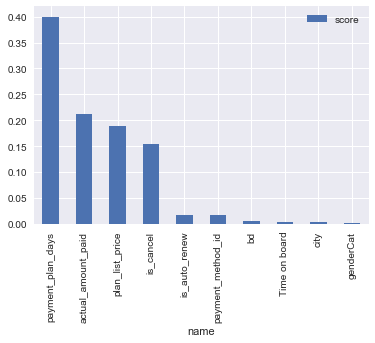

In [30]:
importances.plot.bar(y = 'score', x = 'name', rot=90)

# Build the KMeans Model

Reading data from the csv file into a dataframe

In [4]:
data= pd.read_csv('file:///home/cloudera/Downloads/data.csv',header=0)

Splitting data into train and test datasets

In [5]:
data['split'] = np.random.randn(data.shape[0],1)
msk = np.random.rand(len(data)) <= 0.7
train = data[msk]
test =  data[~msk]

Printing out the data

In [6]:
print('****Training data****')
print(train.head())

print('****Test Data****')
print(test.head())

****Training data****
                                           msno  city  bd  gender  \
0  Uf4DL7z+DPK8Pnb82pao8tC2PfSTuwIvlVDDqUru8SA=     5  32  female   
1  7KuGYecfAiQCvs2ktZg4aaFvcudRNevM2LqsHGVashU=     5  32  female   
3  qqM5POOe8//uuBUoANMczJibwta0YnUhvtPDVGTwjng=     5  32  female   
5  b6I2j4Aqyq0hA2dHf2ZTcl4r23v8ljSFmdy41XkjGlw=     5  32  female   
6  GDO2VDV0YXf2iDh54PT1cnM9Dr/KC7GTPAV/aleCv+k=     5  32  female   

   registered_via  registration_init_time     Column1  Is_Churn  \
0               3                20141221  12/21/2014         1   
1               3                20131207   12/7/2013         0   
3               3                20150920   9/20/2015         0   
5               3                20150205    2/5/2015         0   
6               3                20160808    8/8/2016         0   

   payment_method_id  payment_plan_days    ...     is_cancel  num_25  num_50  \
0                 38                 90    ...             0     8.0     4.0   


In [7]:
print(train.describe())

               city            bd  registered_via  registration_init_time  \
count  16172.000000  16172.000000         16172.0            1.617200e+04   
mean       5.683218     26.902424             3.0            2.013757e+07   
std        2.063882      7.680095             0.0            1.342084e+04   
min        3.000000     13.000000             3.0            2.011121e+07   
25%        4.000000     22.000000             3.0            2.013012e+07   
50%        5.000000     25.000000             3.0            2.014012e+07   
75%        6.000000     30.000000             3.0            2.015041e+07   
max       11.000000    106.000000             3.0            2.017032e+07   

           Is_Churn  payment_method_id  payment_plan_days  plan_list_price  \
count  16172.000000       16172.000000       16172.000000     16172.000000   
mean       0.119404          36.522879          39.402609       191.544831   
std        0.324273           4.216239          49.992253       202.0434

In [8]:
print(test.describe())

              city           bd  registered_via  registration_init_time  \
count  7015.000000  7015.000000          7015.0            7.015000e+03   
mean      5.657163    26.965502             3.0            2.013778e+07   
std       2.042061     7.477060             0.0            1.340809e+04   
min       3.000000    14.000000             3.0            2.011121e+07   
25%       4.000000    22.000000             3.0            2.013012e+07   
50%       5.000000    26.000000             3.0            2.014021e+07   
75%       6.000000    30.000000             3.0            2.015042e+07   
max      11.000000   106.000000             3.0            2.017032e+07   

          Is_Churn  payment_method_id  payment_plan_days  plan_list_price  \
count  7015.000000        7015.000000        7015.000000      7015.000000   
mean      0.115324          36.561796          39.252887       191.219815   
std       0.319436           4.139101          49.939338       203.059733   
min       0.0000

Checking if there are any null values in both the test and train sets.

In [9]:
train.isnull().head()

test.isnull().head()

,msno,city,bd,gender,registered_via,registration_init_time,Column1,Is_Churn,payment_method_id,payment_plan_days,...,is_cancel,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,Loyalty,split
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,True,True,True,True,True,True,True,False,False
10,False,False,False,False,False,False,False,False,False,False,...,False,True,True,True,True,True,True,True,False,False
13,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Checking for any missing values in the train and test datasets.

In [10]:
print("***Missing Values in training dataset***")
print(train.isnull().sum())
print("\n")
print("***Missing Values in test dataset***")
print(test.isnull().sum())

***Missing Values in training dataset***
msno                         0
city                         0
bd                           0
gender                     180
registered_via               0
registration_init_time       0
Column1                      0
Is_Churn                     0
payment_method_id            0
payment_plan_days            0
plan_list_price              0
actual_amount_paid           0
is_auto_renew                0
transaction_date             0
Column2                      0
membership_expire_date       0
Column3                      0
Time on board                0
is_cancel                    0
num_25                    6096
num_50                    6096
num_75                    6096
num_985                   6096
num_100                   6096
num_unq                   6096
total_secs                6096
Loyalty                      0
split                        0
dtype: int64


***Missing Values in test dataset***
msno                         0
city    

Drop the columns which do not have any effect on the Is_churn variable

In [11]:
train.drop('msno',axis=1)
test.drop('msno',axis=1)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16172 entries, 0 to 23186
Data columns (total 28 columns):
msno                      16172 non-null object
city                      16172 non-null int64
bd                        16172 non-null int64
gender                    15992 non-null object
registered_via            16172 non-null int64
registration_init_time    16172 non-null int64
Column1                   16172 non-null object
Is_Churn                  16172 non-null int64
payment_method_id         16172 non-null int64
payment_plan_days         16172 non-null int64
plan_list_price           16172 non-null int64
actual_amount_paid        16172 non-null int64
is_auto_renew             16172 non-null int64
transaction_date          16172 non-null int64
Column2                   16172 non-null object
membership_expire_date    16172 non-null int64
Column3                   16172 non-null object
Time on board             16172 non-null int64
is_cancel                 16172 non-null

Drop the irrelevant values

In [12]:
train = train.drop(['msno','Loyalty','split','city','total_secs',
             'num_100','num_985','num_75','num_50','num_25',
             'Column3','membership_expire_date','Column2','registration_init_time',
              'transaction_date','registered_via','Column1','payment_method_id'],axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16172 entries, 0 to 23186
Data columns (total 10 columns):
bd                    16172 non-null int64
gender                15992 non-null object
Is_Churn              16172 non-null int64
payment_plan_days     16172 non-null int64
plan_list_price       16172 non-null int64
actual_amount_paid    16172 non-null int64
is_auto_renew         16172 non-null int64
Time on board         16172 non-null int64
is_cancel             16172 non-null int64
num_unq               10076 non-null float64
dtypes: float64(1), int64(8), object(1)
memory usage: 1.4+ MB


In [13]:
train = train.drop('num_unq', axis=1)
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16172 entries, 0 to 23186
Data columns (total 9 columns):
bd                    16172 non-null int64
gender                15992 non-null object
Is_Churn              16172 non-null int64
payment_plan_days     16172 non-null int64
plan_list_price       16172 non-null int64
actual_amount_paid    16172 non-null int64
is_auto_renew         16172 non-null int64
Time on board         16172 non-null int64
is_cancel             16172 non-null int64
dtypes: int64(8), object(1)
memory usage: 1.2+ MB


Drop the columns which are not relevant from the test data.

In [14]:
test = test.drop(['msno','Loyalty','split','city','total_secs',
             'num_100','num_985','num_75','num_50','num_25',
             'Column3','membership_expire_date','Column2','registration_init_time',
              'transaction_date','registered_via','Column1','payment_method_id'],axis=1)

test.drop('num_unq',axis = 1)

,bd,gender,Is_Churn,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,Time on board,is_cancel
2,32,female,0,30,180,180,1,1416,1
4,32,female,0,30,149,149,1,1632,0
10,32,female,0,30,149,149,1,1716,0
13,32,female,0,30,149,149,1,812,0
14,32,female,0,30,149,149,1,1748,0
19,32,female,0,30,180,180,1,787,0
21,32,female,0,30,149,149,1,277,0
28,32,female,1,30,180,180,0,1609,0
30,32,female,0,30,180,180,0,199,0
32,37,female,0,30,149,149,1,672,0


Transform the categorical attribute to numerical

In [15]:
labelEncoder = LabelEncoder()

labelEncoder.fit(train['gender'])
labelEncoder.fit(test['gender'])

train['gender'] = labelEncoder.fit_transform(train['gender'].astype(str))
test['gender'] = labelEncoder.fit_transform(test['gender'].astype(str))
train = train.dropna()

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16172 entries, 0 to 23186
Data columns (total 9 columns):
bd                    16172 non-null int64
gender                16172 non-null int64
Is_Churn              16172 non-null int64
payment_plan_days     16172 non-null int64
plan_list_price       16172 non-null int64
actual_amount_paid    16172 non-null int64
is_auto_renew         16172 non-null int64
Time on board         16172 non-null int64
is_cancel             16172 non-null int64
dtypes: int64(9)
memory usage: 1.2 MB


In [17]:
test = test.drop(['Is_Churn'], axis=1)

In [18]:
test = test.drop(['num_unq'], axis = 1)

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7015 entries, 2 to 23176
Data columns (total 8 columns):
bd                    7015 non-null int64
gender                7015 non-null int64
payment_plan_days     7015 non-null int64
plan_list_price       7015 non-null int64
actual_amount_paid    7015 non-null int64
is_auto_renew         7015 non-null int64
Time on board         7015 non-null int64
is_cancel             7015 non-null int64
dtypes: int64(8)
memory usage: 493.2 KB


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16172 entries, 0 to 23186
Data columns (total 9 columns):
bd                    16172 non-null int64
gender                16172 non-null int64
Is_Churn              16172 non-null int64
payment_plan_days     16172 non-null int64
plan_list_price       16172 non-null int64
actual_amount_paid    16172 non-null int64
is_auto_renew         16172 non-null int64
Time on board         16172 non-null int64
is_cancel             16172 non-null int64
dtypes: int64(9)
memory usage: 1.2 MB


In [21]:
X = np.array(train.drop(['Is_Churn'],1).astype(float))
y =  np.array(train['Is_Churn'])

Build the kmeans model using k=2 clusters

In [22]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(X) # Fit the model to the data

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Print the accuracy 

In [23]:
correct = 0
for i in range (len(X)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1,len(predict_me))
    prediction = kmeans.predict(predict_me)
    if(prediction[0] == y[i]):
        correct+=1

In [24]:
print(correct/len(X))

0.528815236211


Use theMinMaxScaler and increase the number of iteration. Enhance the model increasing the max iteration to 600.

In [31]:
kmeans = KMeans(n_clusters=2, max_iter=600, algorithm = 'auto')
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

## Visualize the classifier results

Enhance using the MinMax Scaler to find out if it increases accuracy

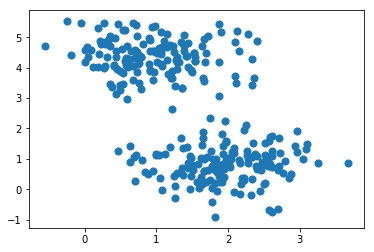

In [32]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
kmeans.fit(X_scaled)

from sklearn.datasets.samples_generator import make_blobs
X,y_true = make_blobs(n_samples = 300, centers=2, cluster_std= 0.60, random_state=0)

plt.scatter(X[:,0],X[:,1],s=50,cmap='viridis');

In [33]:
for i in range (len(X)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1,len(predict_me))
    prediction = kmeans.predict(predict_me)
    if(prediction[0] == y[i]):
        correct+=1

In [34]:
print(correct/len(X))

28.9233333333
